In [2]:
import sys 
import os 
print(os.getcwd())

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import random
from itertools import combinations, groupby
import copy 

PATH = '../Data/'


c:\Users\natha\Google Drive\Grad\Spring2021\ECE696\Demo\ECEMasterProject\RL\rl_env


In [15]:
def gnp_random_connected_graph(n, p):
    """
    Generates a random undirected graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted
    """
    edges = combinations(range(n), 2)
    G = nx.Graph()
    G.add_nodes_from(range(n))
    if p <= 0:
        return G
    if p >= 1:
        return nx.complete_graph(n, create_using=G)
    for _, node_edges in groupby(edges, key=lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < p:
                G.add_edge(*e)
    return G

In [16]:

n = 5
theta = .5
# G = nx.barabasi_albert_graph(100,2)
# G = nx.geographical_threshold_graph(n, theta)
# G = nx.random_geometric_graph(n, theta)
G = gnp_random_connected_graph(n,theta)

class graph_env():
    def __init__(self, G,n, numofhome = 1, numofblackout = 1, numofblackoutws = 0, numofchargingstation = 0, max_actions = 3, blackout_str = 'Brazoria', agents = [None]):
        """Takes in a randomly generated graph, and keeps track of ep infomation
        numofhome - number of homes for agent starting point: int
        numofblackout - number of houses with blackout: int
        numofblackout - number of houses with solarpower: int
        blackout_str - Reads Blackout data from npy file: str
        """
        # self.ev = ev
        # self.day = 0
        self.agents = agents 
        self.ep = 0
        self.i = 0
        self.max_days = 7

        # self.actionsdone = 0
        
        self.max_actions = 1 if ((max_actions -1) < -1)  else  max_actions
        self.max_i = self.max_days * self.max_actions
        # self.max_actions = 1 if ((max_actions -1) < -1)  else  max_actions #action limit can't be less than 0
        self.graph = G
        self.set_cost(n)
        self.color_map = []
        self.size_map = []


        #get all init graph information 
        self.allnodes = list(G.nodes())
        self.node_status = dict.fromkeys(self.allnodes,0)
        

        self.home_nodes, buffer_nodes = self.init_update_graph(self.allnodes, numofhome,5)
        self.blackws_nodes, buffer_nodes = self.init_update_graph(buffer_nodes, numofblackoutws,2)
        self.black_nodes, buffer_nodes = self.init_update_graph(buffer_nodes, numofblackout,1)
        self.charging_nodes, self.buffer_nodes = self.init_update_graph(buffer_nodes, numofchargingstation,4)
        
        #EVs start at home
        self.EV_locations = copy.deepcopy(self.home_nodes)

        #delete None dict 
        try:
            del self.node_status[None]
        except KeyError: 
            pass
        #load blackout data
        try:
            blackout_data = np.load(PATH+blackout_str+'.npy') 
        except OSError: 
            print (f'Could not open/read file: {PATH+blackout_str+".npy"}')
        
        self.get_power_samples(blackout_data, self.max_i)

    def step(self, ev_loc ,action):

        len_max_buffer = len(self.allnodes)-len(self.blackws_nodes)-len(self.black_nodes)

        if self.i == self.max_i or len(self.buffer_nodes) == len_max_buffer:
            self.env_close()
        else: 
            self.power_check()
            self.update_ev_location(self, ev_loc,action)
            self.i +=1 
        return self.ev_for_agents()

    def env_close(self):
        print(f'Ep {self.eps} over, please reinit')
        self.eps += 1

    def get_derived_obs(self):

        pass 
    def reward_output(self):

        pass

    def ev_for_agents(self):
        return self.EV_locations 

    def init_update_graph(self,nodes,num_to_update,val):
        nodes_to_updates, buffer_nodes = self.remove_node(nodes, num_to_update)
        for node in nodes_to_updates:
            # print(home)
            node_update = {node: val}
            self.node_status.update(node_update)
        return nodes_to_updates, buffer_nodes

    def remove_node(self,nodes, numtoremove=1):
        if numtoremove < 1:
            return [None], nodes
        nodes = list(nodes)
        samples = random.sample(nodes, 1)
        new_nodes = list(set(nodes).symmetric_difference(set(samples)))
        return samples, new_nodes

    def set_cost(self,n):

        a = np.round(np.random.rand(n,n)[np.triu_indices(n)],3)
        
        
        for i,e in enumerate(self.graph.edges()):
            self.graph[e[0]][e[1]]["cost"] = a[i]
        pass
    def get_power_samples(self, blackout_data, numofsample):
        self.blackout_samples = []
        totalsamples = len(blackout_data)
        for i in range(numofsample): 
            idx = (i//numofsample)*totalsamples
            self.blackout_samples.append(blackout_data[idx])

    def power_check(self):
        "read from blackout sample to figure out if power is back 1,2 -> 3 "

        p = self.blackout_samples[self.i]
        
        for node in self.black_nodes:
            if node == None:
                pass
            elif random.random() < p:
                pass
            else: 
                #put power back on
                node_update = {node: 3}
                self.node_status.update(node_update)
                self.black_nodes.remove(node)
                self.buffer_nodes.append(node)

        for node in self.blackws_nodes:
            if node == None:
                pass
            elif random.random() < p:
                pass
            else: 
                #put power back on
                node_update = {node: 3}
                self.node_status.update(node_update)
                self.blackws_nodes.remove(node)
                self.buffer_nodes.append(node)

    def _next_day_check(self):
        if self.actionsdone > self.action_limit:
            self.day += 1
            self.actionsdone = 0
    
    def movement_options(self, ev = None):
        if ev == None: 
            ev = self.EV_locations[0]
        routes = self.graph.edges(ev)
        return routes
    
    def update_ev_location(self, ev_loc=None,ev_update = None):
        "ev_update - edge: (s,t), ev - node: s"

        if ev_loc == None: 
            ev_loc = self.EV_locations[0]
        ev_index = self.EV_locations.index(ev_loc)
        if ev_update == None:
            routes = self.graph.edges(ev_loc)
            ev_update = random.sample(list(routes), 1)[0]
        
        # print(ev)
        # print(f'new location: {ev_update}')
        # print(f'EV_index: {ev_index}')
        if ev_loc == ev_update[0]:
            new_ev_loc = ev_update[1]
        else: 
            new_ev_loc = ev_update[0]
        print(f'new location: {new_ev_loc}')
        self.EV_locations[ev_index] = new_ev_loc
    

    def plot_nodes(self, update = True):
        if update == True: 
            self.color_map = []
            self.size_map = []
            # self.shape_map = []
            # print(f'current locations: {self.EV_locations}')
            for key, val in self.node_status.items():
                if val == 1:
                    self.color_map.append('darkgrey')
                    # self.shape_map.append(300)
                elif val == 2:
                    self.color_map.append('lightgrey')
                    # self.shape_map.append(300)
                elif val == 4:
                    self.color_map.append('yellow')
                    # self.shape_map.append(300)
                elif val == 5:
                    self.color_map.append('green')
                else:
                    self.color_map.append('blue')

                if key in self.EV_locations:
                    # print(f'current location: {key}')
                    self.size_map.append(1000)
                else:
                    self.size_map.append(300)

        else:       
            pass

        
        edge_labels = nx.get_edge_attributes(self.graph,'cost')
        pos=nx.spring_layout(self.graph)
        # print(edge_labels)
        nx.draw_networkx_edge_labels(self.graph,pos = pos, edge_labels= edge_labels )
        nx.draw(self.graph,pos = pos, node_color=self.color_map, node_size = self.size_map, with_labels=True )

        
    def plot_nodes_c(self, update = True):
        if update == True: 
            self.color_map = []
            for key, val in self.node_status.items():
                self.color_map.append(f'C{val}')
                if key in self.EV_locations:
                    # print(key)
                    self.size_map.append(1000)
                else:
                    self.size_map.append(300)
        else:       
            pass
        nx.draw(self.graph, node_color=self.color_map, node_size = self.size_map, with_labels=True)
        

env = graph_env(G,n)

print(env.node_status)




{0: 0, 1: 5, 2: 0, 3: 0, 4: 1}


new location: 2


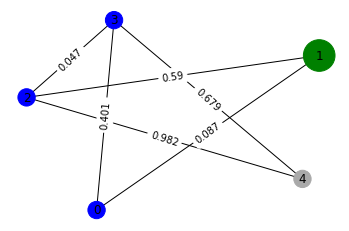

In [17]:
env.plot_nodes()
# plt.pause(1)
env.update_ev_location()

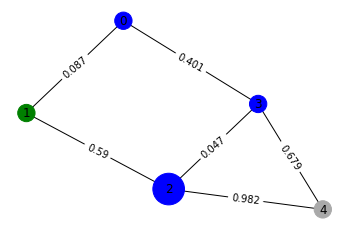

In [18]:
env.plot_nodes()

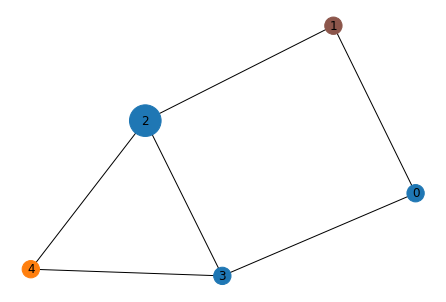

In [19]:
env.plot_nodes_c()

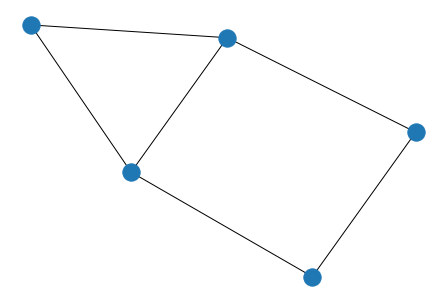

In [20]:
nx.draw_spring(G)

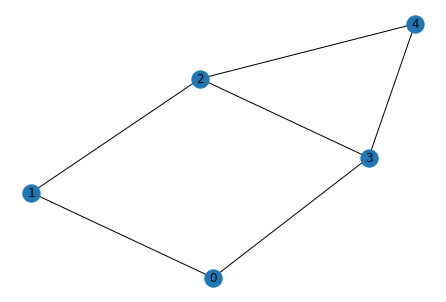

In [21]:
nx.draw(G, with_labels=1)

(array([3., 0., 0., 0., 0., 0., 0., 0., 0., 2.]),
 array([2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ]),
 <a list of 10 Patch objects>)

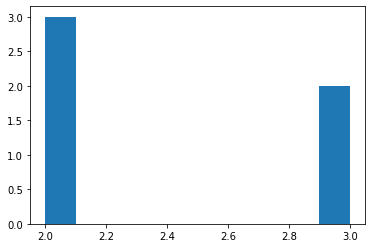

In [22]:
plt.hist([v for k,v in nx.degree(G)])

(array([3., 0., 0., 0., 0., 0., 0., 0., 0., 2.]),
 array([0.66666667, 0.68      , 0.69333333, 0.70666667, 0.72      ,
        0.73333333, 0.74666667, 0.76      , 0.77333333, 0.78666667,
        0.8       ]),
 <a list of 10 Patch objects>)

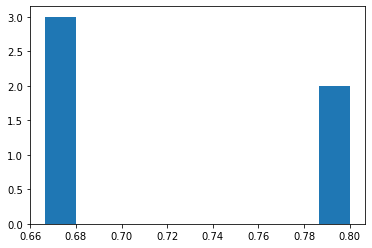

In [23]:
plt.hist(nx.centrality.closeness_centrality(G).values())

In [24]:
nx.diameter(G)

2

In [25]:
nx.cluster.average_clustering(G)

0.3333333333333333

In [26]:
# nodes = list(G.nodes())
# samples = sample(nodes, 1)
# new_nodes = list(set(nodes).symmetric_difference(set(samples)))
# print(nodes)
# print(samples)
# print(new_nodes)

In [27]:
list([1,2,3])

[1, 2, 3]

In [28]:
A = np.random.rand(n,n)
triidx =np.triu_indices(n)
# B = A@A.T
# np.triu(A)
A[triidx]

array([0.8454103 , 0.83656923, 0.33647965, 0.35724428, 0.01770365,
       0.08890779, 0.89744702, 0.21705101, 0.35583892, 0.38043846,
       0.21191528, 0.89751809, 0.20145387, 0.27987995, 0.82399487])

In [29]:
# https://plotly.com/python/network-graphs/
# https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python



n = 5
theta = .5
# G = nx.barabasi_albert_graph(100,2)
# G = nx.geographical_threshold_graph(n, theta)
# G = nx.random_geometric_graph(n, theta)
G = gnp_random_connected_graph(n,.5)

class _graph_env():
    "Takes in a randomly generated graph, and keeps track of ep infomation"
    def __init__(self, G, numofhome = 1, numofblackout = 1, numofblackoutwps =0):
        self.allnodes = list(G.nodes())
        self.home, buffer_nodes = self.remove_node(self.allnodes, numofhome)
        self.clientwpowerstation, buffer_nodes = self.remove_node(buffer_nodes, numofblackoutwps)
        self.client, buffer_nodes = self.remove_node(buffer_nodes, numofblackout)
        self.buffer_nodes = buffer_nodes
        # print(G.edges(node))

    def remove_node(self,nodes, numtoremove=1):
        if numtoremove < 1:
            return None, nodes
        nodes = list(nodes)
        samples = random.sample(nodes, 1)
        new_nodes = list(set(nodes).symmetric_difference(set(samples)))
        return samples, new_nodes

# env = graph_env(G)

# print(env.home)
# print(env.clientwpowerstation)
# print(env.client)
# print(env.buffer_nodes)




In [30]:
n = 5
G = nx.path_graph(n)

In [36]:
# def set_cost(G,n):
#     a = np.round(np.random.rand(n,n)[np.triu_indices(n)],3)
    
#     for i,e in enumerate(G.edges()):
#         G[e[0]][e[1]]["cost"] = a[i]
def set_cost(G,n):
    a = np.round(np.random.rand(n,n)[np.triu_indices(n)],3)
    
    for i,e in enumerate(G.edges()):
        G[e[0]][e[1]]["cost"] = a[i]


    G.nodes[2]["cost"] = 30 
    G.nodes[4]["cost"] = 30 
            # print(node)
    
    G.nodes[1]["cost"] = 20

    G.nodes[0]["cost"] = 0
set_cost(G, n)


In [37]:
G.edges()

EdgeView([(0, 1), (1, 2), (2, 3), (3, 4)])

In [38]:
len_path = dict(nx.all_pairs_dijkstra(G,weight='cost'))
len_path

{0: ({0: 0, 1: 0.771, 2: 1.274, 3: 1.705, 4: 2.2030000000000003},
  {0: [0], 1: [0, 1], 2: [0, 1, 2], 3: [0, 1, 2, 3], 4: [0, 1, 2, 3, 4]}),
 1: ({1: 0, 2: 0.503, 0: 0.771, 3: 0.9339999999999999, 4: 1.432},
  {1: [1], 0: [1, 0], 2: [1, 2], 3: [1, 2, 3], 4: [1, 2, 3, 4]}),
 2: ({2: 0, 3: 0.431, 1: 0.503, 4: 0.929, 0: 1.274},
  {2: [2], 1: [2, 1], 3: [2, 3], 4: [2, 3, 4], 0: [2, 1, 0]}),
 3: ({3: 0, 2: 0.431, 4: 0.498, 1: 0.9339999999999999, 0: 1.705},
  {3: [3], 2: [3, 2], 4: [3, 4], 1: [3, 2, 1], 0: [3, 2, 1, 0]}),
 4: ({4: 0, 3: 0.498, 2: 0.929, 1: 1.432, 0: 2.203},
  {4: [4], 3: [4, 3], 2: [4, 3, 2], 1: [4, 3, 2, 1], 0: [4, 3, 2, 1, 0]})}

In [39]:
G.nodes[1]["cost"]

20

In [40]:

for node in [0, 1, 2, 3, 4]:
    print(f"3 - {node}: {len_path[3][0][node]}")

3 - 0: 1.705
3 - 1: 0.9339999999999999
3 - 2: 0.431
3 - 3: 0
3 - 4: 0.498


In [4]:
print(os.getcwd())

c:\Users\natha\Google Drive\Grad\Spring2021\ECE696\Demo\ECEMasterProject\RL\rl_env


In [5]:
data = pd.read_hdf('../../models/Qtables/qtable_ep_0.pickle.h5')

In [6]:
data

,nothing,chargeup,unload,0,1,2,3,4
"(5, 0, 1, 0.348, 0, 0.86, 0, 0.04, 0, 0.316)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(5, 0.04, 1, 0.353, 0, 0.82, 0, 0, 0, 0.321)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(5, 0.316, 1, 0.032, 0, 0.9530000000000001, 0, 0.321, 0, 0)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(5, 0.348, 1, 0, 0, 0.921, 0, 0.353, 0, 0.032)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
data = pd.read_hdf('../../models/Qtables/qtable_ep_1000.pickle.h5')

In [20]:
data

,nothing,chargeup,unload,0,1,2,3,4
"(0, 0.8, 0, 0.4, 5, 0, 0, 1.7, 1, 0.7, 40.0)",0.000000,0.000162,0.000000,0.000054,0.000000,0.000000,0.000108,0.0
"(0, 1.2, 0, 0, 5, 0.4, 0, 2.1, 1, 1.1, 39.9)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
"(0, 0.8, 0, 0.4, 5, 0, 0, 1.7, 1, 0.7, 39.8)",0.000054,0.000054,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
"(0, 0, 0, 1.2, 5, 0.8, 0, 2.5, 1, 1.5, 39.8)",0.000110,0.000162,0.000107,0.000000,0.000054,0.000000,0.000000,0.0
"(0, 0, 0, 1.2, 5, 0.8, 0, 2.5, 3, 1.5, 39.8)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...
"(0, 0, 5, 0.8, 0, 0.4, 1, 0.4, 0, 0.1, 38.9)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
"(0, 0.4, 5, 1.2, 0, 0.8, 1, 0, 0, 0.5, 38.8)",0.000000,0.000000,0.000000,0.000515,0.000000,0.000000,0.000515,0.0
"(0, 0, 5, 0.8, 0, 0.4, 1, 0.4, 0, 0.1, 38.7)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000515,0.000000,0.0
"(0, 0.4, 5, 0.7, 0, 0, 1, 0.8, 0, 0.5, 38.6)",0.000000,0.000000,0.000000,0.000000,0.000920,0.000000,0.000000,0.0


In [ ]:
nothing = []
chargeup =